In [21]:
# PM2.5 7-Day Prediction Script
# ส่วนที่ 1: การนำเข้าไลบรารี
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import joblib
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# ส่วนที่ 2: โหลดข้อมูลที่ทำความสะอาดแล้ว
print("กำลังโหลดข้อมูลที่ทำความสะอาดแล้ว...")
try:
    # ปรับเปลี่ยนชื่อไฟล์ตามที่คุณบันทึกไว้
    cleaned_file_path = r'C:\python\pm2_5\data\export-4B7B6566022D-1d_clean_no_overfit.xlsx'
    df = pd.read_excel(cleaned_file_path)
    
    # แปลง timestamp เป็น datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    print(f"โหลดข้อมูลสำเร็จ: {len(df)} แถว")
except Exception as e:
    print(f"เกิดข้อผิดพลาดในการโหลดข้อมูล: {e}")
    exit()


กำลังโหลดข้อมูลที่ทำความสะอาดแล้ว...
โหลดข้อมูลสำเร็จ: 489 แถว


In [23]:
# ส่วนที่ 3: โหลดโมเดลที่เทรนไว้แล้ว
print("กำลังโหลดโมเดล...")
try:
    # ปรับเปลี่ยนชื่อโมเดลตามที่คุณบันทึกไว้
    pm25_model = joblib.load('pm25_prediction_model_optimized.pkl')
    temp_model = joblib.load('temperature_prediction_model_optimized.pkl')
    print("โหลดโมเดลสำเร็จ")
except Exception as e:
    print(f"เกิดข้อผิดพลาดในการโหลดโมเดล: {e}")
    exit()

กำลังโหลดโมเดล...
โหลดโมเดลสำเร็จ


In [24]:
# ส่วนที่ 4: สร้างฟังก์ชันสำหรับการเตรียมข้อมูล
def prepare_time_series_features(dataframe):
    """เตรียมข้อมูลสำหรับการทำนาย โดยลด overfitting"""
    df_copy = dataframe.copy()

    # แปลง timestamp เป็น datetime
    df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])

    # เรียงข้อมูลตามเวลา
    df_copy = df_copy.sort_values('timestamp')

    # ใช้ Lag Features แค่ 3 วันแทน 7 วัน
    for i in range(1, 4):
        df_copy[f'pm_2_5_lag_{i}'] = df_copy['pm_2_5'].shift(i)
        df_copy[f'temperature_lag_{i}'] = df_copy['temperature'].shift(i)
        df_copy[f'humidity_lag_{i}'] = df_copy['humidity'].shift(i)

    # ใช้ Exponential Moving Average (EMA) แทน Rolling Mean
    df_copy['pm_2_5_ema_3'] = df_copy['pm_2_5'].ewm(span=3, adjust=False).mean()
    df_copy['pm_2_5_ema_7'] = df_copy['pm_2_5'].ewm(span=7, adjust=False).mean()

    # คุณลักษณะเกี่ยวกับเวลา
    df_copy['day_of_week'] = df_copy['timestamp'].dt.dayofweek
    df_copy['hour'] = df_copy['timestamp'].dt.hour
    df_copy['month'] = df_copy['timestamp'].dt.month

    # ใช้ Cyclical Encoding สำหรับวันในสัปดาห์
    df_copy['day_sin'] = np.sin(df_copy['day_of_week'] * (2 * np.pi / 7))
    df_copy['day_cos'] = np.cos(df_copy['day_of_week'] * (2 * np.pi / 7))

    # สร้างฟีเจอร์ใหม่ที่เกี่ยวข้องกับ temperature และ humidity
    df_copy['temp_humidity_ratio'] = df_copy['temperature'] / df_copy['humidity']
    df_copy['temp_humidity_diff'] = df_copy['temperature'] - df_copy['humidity']

    return df_copy

In [25]:
# ส่วนที่ 5: ทำนาย 7 วัน (แก้ปัญหา KeyError)
def predict_next_7_days(df, pm25_model, temp_model):
    """ทำนายค่า PM2.5 และอุณหภูมิ ล่วงหน้า 7 วัน พร้อมแก้ปัญหาคอลัมน์หาย"""

    # เตรียมข้อมูล
    forecast_df = prepare_time_series_features(df)
    latest_date = forecast_df['timestamp'].max()
    last_rows = forecast_df[forecast_df['timestamp'] == latest_date].copy()

    if len(last_rows) == 0:
        last_rows = forecast_df.iloc[-1:].copy()
        latest_date = last_rows['timestamp'].iloc[0]

    # คอลัมน์ที่ใช้ทำนาย
    important_features = [
        'temperature', 'humidity', 'pm_2_5_lag_1', 'pm_2_5_lag_2', 
        'pm_2_5_lag_3', 'pm_2_5_ema_3', 'pm_2_5_ema_7',
        'day_sin', 'day_cos', 'hour', 'month',
        'temp_humidity_ratio', 'temp_humidity_diff'
    ]

    # ตรวจสอบว่าคอลัมน์มีครบไหม ถ้าไม่มีให้เติมค่า default
    for col in important_features:
        if col not in last_rows.columns:
            last_rows[col] = 0  # ค่า default (หรือใช้ median ก็ได้)

    # เตรียม DataFrame เก็บผลการทำนาย
    forecast_results = []
    current_input = last_rows.copy()

    # ทำนายทีละวัน
    for i in range(1, 8):
        prediction_date = latest_date + timedelta(days=i)
        current_input['timestamp'] = prediction_date
        current_input['day_of_week'] = prediction_date.dayofweek
        current_input['month'] = prediction_date.month
        current_input['hour'] = 12  # สมมติเป็นช่วงกลางวัน

        # ปรับ cyclical features
        current_input['day_sin'] = np.sin(current_input['day_of_week'] * (2 * np.pi / 7))
        current_input['day_cos'] = np.cos(current_input['day_of_week'] * (2 * np.pi / 7))

        # ใช้เฉพาะ features ที่จำเป็น
        prediction_features = current_input[important_features].copy()

        try:
            pm25_prediction = pm25_model.predict(prediction_features)[0]
            temp_prediction = temp_model.predict(prediction_features)[0]
        except Exception as e:
            print(f"เกิดข้อผิดพลาดในการทำนาย: {e}")
            pm25_prediction = current_input['pm_2_5_ema_3'].values[0]  # ใช้ค่า EMA แทน
            temp_prediction = current_input['temperature'].values[0]  # ใช้ค่าเดิมแทน

        # บันทึกผลการทำนาย
        forecast_results.append({
            'date': prediction_date.strftime('%Y-%m-%d'),
            'day_of_week': prediction_date.strftime('%A'),
            'pm_2_5_predicted': pm25_prediction,
            'temperature_predicted': temp_prediction
        })

        # อัปเดตค่า Lag และ EMA
        current_input['pm_2_5_lag_1'] = pm25_prediction
        current_input['pm_2_5_lag_2'] = current_input['pm_2_5_lag_1'].values[0]
        current_input['pm_2_5_lag_3'] = current_input['pm_2_5_lag_2'].values[0]

        # อัปเดต EMA
        prev_values = [row['pm_2_5_predicted'] for row in forecast_results[-3:]]
        current_input['pm_2_5_ema_3'] = np.mean(prev_values) if len(prev_values) == 3 else np.mean(prev_values)

        prev_values = [row['pm_2_5_predicted'] for row in forecast_results[-7:]]
        current_input['pm_2_5_ema_7'] = np.mean(prev_values) if len(prev_values) == 7 else np.mean(prev_values)

    return pd.DataFrame(forecast_results)

In [26]:
# ส่วนที่ 6: การวิเคราะห์คุณภาพอากาศตามมาตรฐาน
def analyze_air_quality(pm25_value):
    """แปลงค่า PM2.5 เป็นระดับคุณภาพอากาศ"""
    if pm25_value <= 12:
        return "ดี (Good)"
    elif pm25_value <= 35.4:
        return "ปานกลาง (Moderate)"
    elif pm25_value <= 55.4:
        return "ไม่ดีต่อกลุ่มเสี่ยง (Unhealthy for Sensitive Groups)"
    elif pm25_value <= 150.4:
        return "ไม่ดีต่อสุขภาพ (Unhealthy)"
    elif pm25_value <= 250.4:
        return "ไม่ดีต่อสุขภาพอย่างมาก (Very Unhealthy)"
    else:
        return "อันตราย (Hazardous)"


In [ ]:
# ส่วนที่ 7: การทำนายและแสดงผล
# เตรียมข้อมูลเพิ่มเติม
df_with_features = prepare_time_series_features(df)

# ทำนายค่า PM2.5 และอุณหภูมิ ล่วงหน้า 7 วัน
print("\nกำลังทำนายค่า PM2.5 และอุณหภูมิ ล่วงหน้า 7 วัน...")
forecast_result = predict_next_7_days(df_with_features, pm25_model, temp_model)

# เพิ่มการวิเคราะห์คุณภาพอากาศ
forecast_result['air_quality'] = forecast_result['pm_2_5_predicted'].apply(analyze_air_quality)

# แสดงผลการทำนาย
print("\nผลการทำนายค่า PM2.5 และอุณหภูมิ ล่วงหน้า 7 วัน:")
print(forecast_result[['date', 'day_of_week', 'pm_2_5_predicted', 'temperature_predicted', 'air_quality']])


กำลังทำนายค่า PM2.5 และอุณหภูมิ ล่วงหน้า 7 วัน...
เกิดข้อผิดพลาดในการทำนาย: "['pm_10', 'day_of_week'] not in index"
เกิดข้อผิดพลาดในการทำนาย: "['pm_10', 'day_of_week'] not in index"
เกิดข้อผิดพลาดในการทำนาย: "['pm_10', 'day_of_week'] not in index"
เกิดข้อผิดพลาดในการทำนาย: "['pm_10', 'day_of_week'] not in index"
เกิดข้อผิดพลาดในการทำนาย: "['pm_10', 'day_of_week'] not in index"
เกิดข้อผิดพลาดในการทำนาย: "['pm_10', 'day_of_week'] not in index"
เกิดข้อผิดพลาดในการทำนาย: "['pm_10', 'day_of_week'] not in index"

ผลการทำนายค่า PM2.5 และอุณหภูมิ ล่วงหน้า 7 วัน:
         date day_of_week  pm_2_5_predicted  temperature_predicted air_quality
0  2023-03-19      Sunday         10.428646              25.208512   ดี (Good)
1  2023-03-20      Monday         10.428646              25.208512   ดี (Good)
2  2023-03-21     Tuesday         10.428646              25.208512   ดี (Good)
3  2023-03-22   Wednesday         10.428646              25.208512   ดี (Good)
4  2023-03-23    Thursday         10.428646

บันทึกกราฟการทำนายไปยัง 'pm25_forecast_7days.png'


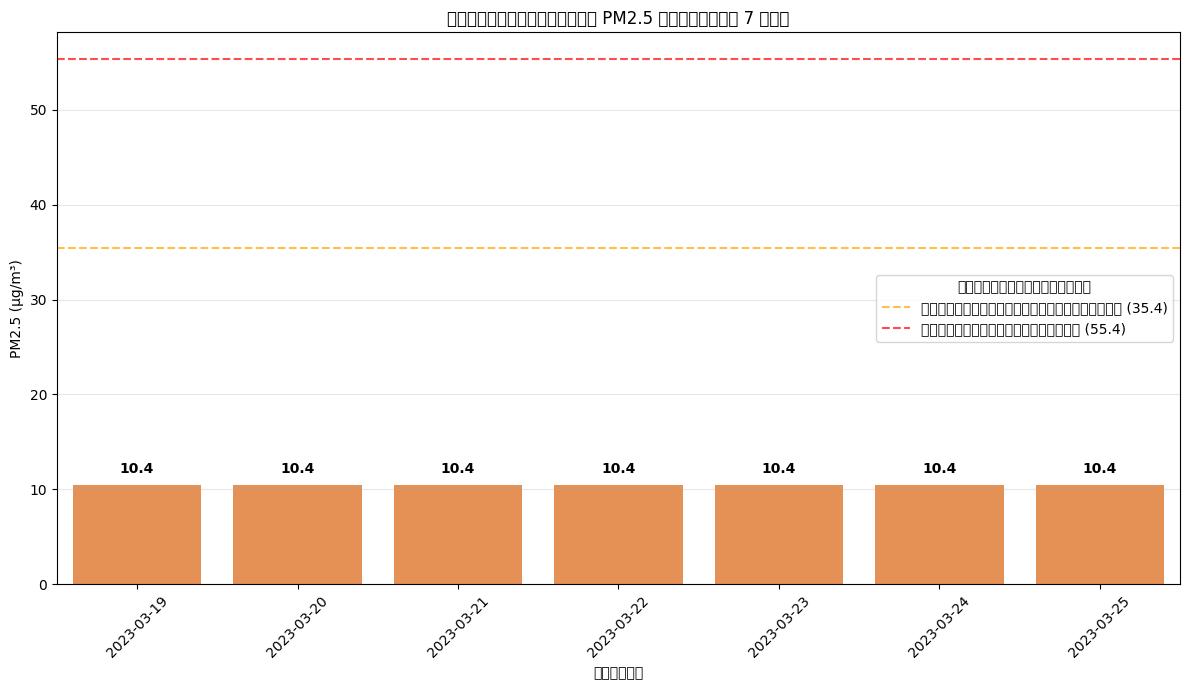

In [27]:

# ส่วนที่ 8: สร้างกราฟแสดงผลการทำนาย
plt.figure(figsize=(12, 7))

# กราฟแท่งแสดงค่า PM2.5 รายวัน
ax1 = sns.barplot(x='date', y='pm_2_5_predicted', data=forecast_result, 
                 hue='air_quality', palette='YlOrRd', legend=False)
plt.xlabel('วันที่')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('การทำนายค่าฝุ่น PM2.5 ล่วงหน้า 7 วัน')

# ตั้งค่าแกน X
plt.xticks(rotation=45)

# เพิ่มค่า PM2.5 บนแท่งกราฟ
for i, row in enumerate(forecast_result.itertuples()):
    ax1.text(i, row.pm_2_5_predicted + 1, f'{row.pm_2_5_predicted:.1f}',
             ha='center', va='bottom', fontweight='bold')

# เพิ่มเส้นแสดงเกณฑ์คุณภาพอากาศ
plt.axhline(y=35.4, color='orange', linestyle='--', alpha=0.7, 
            label='เริ่มไม่ดีต่อกลุ่มเสี่ยง (35.4)')
plt.axhline(y=55.4, color='red', linestyle='--', alpha=0.7,
            label='เริ่มไม่ดีต่อสุขภาพ (55.4)')

plt.legend(title='ระดับคุณภาพอากาศ')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# บันทึกกราฟ
plt.savefig('pm25_forecast_7days.png')
print("บันทึกกราฟการทำนายไปยัง 'pm25_forecast_7days.png'")

# แสดงกราฟ
plt.show()


In [ ]:
# ส่วนที่ 9: บันทึกผลการทำนาย
# บันทึกผลการทำนายเป็นไฟล์ CSV
forecast_result.to_csv('pm25_forecast_7days.csv', index=False)
print("บันทึกผลการทำนายไปยัง 'pm25_forecast_7days.csv'")

print("\nการทำนายเสร็จสมบูรณ์!")